# From Rattle to Roar: Optimizer Showdown for MambaStock on S&P500
## Maria Garmonina (mkg2169@columbia.edu)
## Alena Chan (ac5477@columbia.edu)

This project investigates how different optimizers (from SGD and RMSProp to AdamW and Lion) perform on predicting returns on the S&P 500 index.

## Data Loading & Preprocessing

In [1]:
!pip install pytorch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.8/240.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [34]:
import pandas as pd
import math
from dataclasses import dataclass
from typing import Iterable, Union, Callable, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from argparse import Namespace
import time

from itertools import product
import pytorch_optimizer

import os
import csv
import ast
import re

import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import textwrap
from itertools import cycle

from pytorch_optimizer.base.optimizer import BaseOptimizer

In [35]:
# using https://github.com/Shanlearning/SP-500-Stock-Prediction/blob/master/2-cleaned_data/dat_sp500_index.csv


!git clone https://github.com/maria-garmonina/snakes-on-trading-floor
%cd snakes-on-trading-floor

dat_sp500 = pd.read_csv('dat_sp500_index.csv')
dat_sp500['date'] = pd.to_datetime(dat_sp500['date'], format='%Y-%m-%d')

Cloning into 'snakes-on-trading-floor'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 652.69 KiB | 3.93 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/snakes-on-trading-floor/snakes-on-trading-floor


In [5]:
dat_sp500.head() # view the data

,Unnamed: 0,date,adj close,return_t,return_t_plus_1,adx,trix,adxr,cci,macdh,...,kdjk,wr_14,atr_percent,atr,cmf,PbRatio,PeRatio,PsRatio,spsentiment,sentiment
0,0,2000-01-07,7.258513,-0.029308,0.019838,38.445890,0.140107,35.649951,-62.799815,-3.818169,...,53.357341,62.057117,0.014642,20.779540,-0.016252,3.489550,24.709673,1.947404,-0.972755,-0.016504
1,1,2000-01-14,7.278351,0.019838,0.000608,19.705435,0.073161,28.025151,19.322511,-2.056999,...,61.593407,29.258373,0.015591,22.583700,0.080689,3.505730,25.617738,2.049359,0.877906,0.018608
2,2,2000-01-21,7.278960,0.000608,-0.038482,16.326078,0.073379,19.296268,38.462605,-0.190725,...,70.276137,28.416567,0.014763,21.399297,0.069289,3.582680,25.189682,2.017066,-0.714418,0.162971
3,3,2000-01-28,7.240477,-0.038482,0.012564,33.189814,0.013923,24.794642,-122.908328,-6.396588,...,31.475174,78.432836,0.017436,24.304453,-0.066381,3.329056,24.939210,1.942700,0.799086,0.028568
4,4,2000-02-04,7.253042,0.012564,0.002699,41.397500,-0.091226,40.042367,-35.082052,-4.451932,...,43.792029,48.529655,0.018987,26.812518,0.011667,3.290000,24.478051,1.985449,-0.871653,0.044020


In [6]:
dat_sp500 = dat_sp500.drop('Unnamed: 0', axis=1) # drop the Unnamed col

In [7]:
dat_sp500.info() # see description of variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1043 non-null   datetime64[ns]
 1   adj close        1043 non-null   float64       
 2   return_t         1043 non-null   float64       
 3   return_t_plus_1  1043 non-null   float64       
 4   adx              1043 non-null   float64       
 5   trix             1043 non-null   float64       
 6   adxr             1043 non-null   float64       
 7   cci              1043 non-null   float64       
 8   macdh            1043 non-null   float64       
 9   rsi_14           1043 non-null   float64       
 10  kdjk             1043 non-null   float64       
 11  wr_14            1043 non-null   float64       
 12  atr_percent      1043 non-null   float64       
 13  atr              1043 non-null   float64       
 14  cmf              1043 non-null   float64

In [8]:
dat_sp500 = dat_sp500[dat_sp500['spsentiment'].notna()] # drop NA

In [9]:
ret_t_plus_1 = dat_sp500.pop('return_t_plus_1').values # target
dat_sp500.drop(columns=['adj close'], inplace=True)

In [10]:
X_all = dat_sp500.iloc[:,1:].values # [return_t, adx, ..., sentiment]
y_all = ret_t_plus_1 # length N

## Model

In [11]:
# from https://github.com/zshicode/MambaStock


"""

This file closely follows the mamba_simple.py from the official Mamba implementation, and the mamba-minimal by @johnma2006.
The major differences are :
-the convolution is done with torch.nn.Conv1d
-the selective scan is done in PyTorch

A sequential version of the selective scan is also available for comparison.

- A Mamba model is composed of several layers, which are ResidualBlock.
- A ResidualBlock is composed of a MambaBlock, a normalization, and a residual connection : ResidualBlock(x) = mamba(norm(x)) + x
- This leaves us with the MambaBlock : its input x is (B, L, D) and its outputs y is also (B, L, D) (B=batch size, L=seq len, D=model dim).
First, we expand x into (B, L, 2*ED) (where E is usually 2) and split it into x and z, each (B, L, ED).
Then, we apply the short 1d conv to x, followed by an activation function (silu), then the SSM.
We then multiply it by silu(z).
See Figure 3 of the paper (page 8) for a visual representation of a MambaBlock.

"""

@dataclass
class MambaConfig:
    d_model: int # D
    n_layers: int
    dt_rank: Union[int, str] = 'auto'
    d_state: int = 16 # N in paper/comments
    expand_factor: int = 2 # E in paper/comments
    d_conv: int = 4

    dt_min: float = 0.001
    dt_max: float = 0.1
    dt_init: str = "random" # "random" or "constant"
    dt_scale: float = 1.0
    dt_init_floor = 1e-4

    bias: bool = False
    conv_bias: bool = True

    pscan: bool = False # DO NOT use parallel scan mode or sequential mode when training; aboba

    def __post_init__(self):
        self.d_inner = self.expand_factor * self.d_model # E*D = ED in comments

        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

class Mamba(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        self.layers = nn.ModuleList([ResidualBlock(config) for _ in range(config.n_layers)])
        self.norm_f = RMSNorm(config.d_model)

    def forward(self, x):
        # x : (B, L, D)

        # y : (B, L, D)

        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x)

        return x

    def step(self, x, caches):
        # x : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        # y : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        for i, layer in enumerate(self.layers):
            x, caches[i] = layer.step(x, caches[i])

        return x, caches

class ResidualBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.mixer = MambaBlock(config)
        self.norm = RMSNorm(config.d_model)

    def forward(self, x):
        # x : (B, L, D)

        # output : (B, L, D)

        output = self.mixer(self.norm(x)) + x
        return output

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
                # h : (B, ED, N)
                # inputs: (B, ED, d_conv-1)

        # output : (B, D)
        # cache : (h, inputs)

        output, cache = self.mixer.step(self.norm(x), cache)
        output = output + x
        return output, cache

class MambaBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        # projects block input from D to 2*ED (two branches)
        self.in_proj = nn.Linear(config.d_model, 2 * config.d_inner, bias=config.bias)

        self.conv1d = nn.Conv1d(in_channels=config.d_inner, out_channels=config.d_inner,
                              kernel_size=config.d_conv, bias=config.conv_bias,
                              groups=config.d_inner,
                              padding=config.d_conv - 1)

        # projects x to input-dependent Δ, B, C
        self.x_proj = nn.Linear(config.d_inner, config.dt_rank + 2 * config.d_state, bias=False)

        # projects Δ from dt_rank to d_inner
        self.dt_proj = nn.Linear(config.dt_rank, config.d_inner, bias=True)

        # dt initialization
        # dt weights
        dt_init_std = config.dt_rank**-0.5 * config.dt_scale
        if config.dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif config.dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError

        # dt bias
        dt = torch.exp(
            torch.rand(config.d_inner) * (math.log(config.dt_max) - math.log(config.dt_min)) + math.log(config.dt_min)
        ).clamp(min=config.dt_init_floor)
        inv_dt = dt + torch.log(-torch.expm1(-dt)) # inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        #self.dt_proj.bias._no_reinit = True # initialization would set all Linear.bias to zero, need to mark this one as _no_reinit
        # todo : explain why removed

        # S4D real initialization
        A = torch.arange(1, config.d_state + 1, dtype=torch.float32).repeat(config.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A)) # why store A in log ? to keep A < 0 (cf -torch.exp(...)) ? for gradient stability ?
        self.D = nn.Parameter(torch.ones(config.d_inner))

        # projects block output from ED back to D
        self.out_proj = nn.Linear(config.d_inner, config.d_model, bias=config.bias)

    def forward(self, x):
        # x : (B, L, D)

        # y : (B, L, D)

        _, L, _ = x.shape

        xz = self.in_proj(x) # (B, L, 2*ED)
        x, z = xz.chunk(2, dim=-1) # (B, L, ED), (B, L, ED)

        # x branch
        x = x.transpose(1, 2) # (B, ED, L)
        x = self.conv1d(x)[:, :, :L] # depthwise convolution over time, with a short filter
        x = x.transpose(1, 2) # (B, L, ED)

        x = F.silu(x)
        y = self.ssm(x)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, L, D)

        return output

    def ssm(self, x):
        # x : (B, L, ED)

        # y : (B, L, ED)

        A = -torch.exp(self.A_log.float()) # (ED, N)
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, L, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, L, dt_rank), (B, L, N), (B, L, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, L, ED)

        if self.config.pscan:
            y = self.selective_scan(x, delta, A, B, C, D)
        else:
            y = self.selective_scan_seq(x, delta, A, B, C, D)

        return y

    def selective_scan(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)

        hs = pscan(deltaA, BX)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    def selective_scan_seq(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        _, L, _ = x.shape

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)

        h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)
        hs = []

        for t in range(0, L):
            h = deltaA[:, t] * h + BX[:, t]
            hs.append(h)

        hs = torch.stack(hs, dim=1) # (B, L, ED, N)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    # -------------------------- inference -------------------------- #
    """
    Concerning auto-regressive inference

    The cool part of using Mamba : inference is constant wrt to sequence length
    We just have to keep in cache, for each layer, two things :
    - the hidden state h (which is (B, ED, N)), as you typically would when doing inference with a RNN
    - the last d_conv-1 inputs of the layer, to be able to compute the 1D conv which is a convolution over the time dimension
      (d_conv is fixed so this doesn't incur a growing cache as we progress on generating the sequence)
      (and d_conv is usually very small, like 4, so we just have to "remember" the last 3 inputs)

    Concretely, these two quantities are put inside a cache tuple, and are named h and inputs respectively.
    h is (B, ED, N), and inputs is (B, ED, d_conv-1)
    The MambaBlock.step() receives this cache, and, along with outputing the output, alos outputs the updated cache for the next call.

    The cache object is initialized as follows : (None, torch.zeros()).
    When h is None, the selective scan function detects it and start with h=0.
    The torch.zeros() isn't a problem (it's same as just feeding the input, because the conv1d is padded)

    As we need one such cache variable per layer, we store a caches object, which is simply a list of cache object. (See mamba_lm.py)
    """

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
                # h : (B, ED, N)
                # inputs : (B, ED, d_conv-1)

        # y : (B, D)
        # cache : (h, inputs)

        h, inputs = cache

        xz = self.in_proj(x) # (B, 2*ED)
        x, z = xz.chunk(2, dim=1) # (B, ED), (B, ED)

        # x branch
        x_cache = x.unsqueeze(2)
        x = self.conv1d(torch.cat([inputs, x_cache], dim=2))[:, :, self.config.d_conv-1] # (B, ED)

        x = F.silu(x)
        y, h = self.ssm_step(x, h)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, D)

        # prepare cache for next call
        inputs = torch.cat([inputs[:, :, 1:], x_cache], dim=2) # (B, ED, d_conv-1)
        cache = (h, inputs)

        return output, cache

    def ssm_step(self, x, h):
        # x : (B, ED)
        # h : (B, ED, N)

        # y : (B, ED)
        # h : (B, ED, N)

        A = -torch.exp(self.A_log.float()) # (ED, N) # todo : ne pas le faire tout le temps, puisque c'est indépendant de la timestep
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, dt_rank), (B, N), (B, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(1) # (B, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, ED, N)

        if h is None:
            h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)

        h = deltaA * h + BX # (B, ED, N)

        y = (h @ C.unsqueeze(-1)).squeeze(2) # (B, ED, N) @ (B, N, 1) -> (B, ED, 1)

        y = y + D * x

        # todo : pq h.squeeze(1) ??
        return y, h.squeeze(1)

# taken straight from https://github.com/johnma2006/mamba-minimal/blob/master/model.py
class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()

        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output

In [12]:
# wrapper class
class Net(nn.Module):
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.config = MambaConfig(d_model=args.hidden, n_layers=args.layer)
        self.mamba = nn.Sequential(
            nn.Linear(in_dim,args.hidden),
            Mamba(self.config),
            nn.Linear(args.hidden,out_dim),
            nn.Tanh()
        )

    def forward(self,x):
        x = self.mamba(x)
        return x.flatten()

## Profiling Existing Optimizers

In [6]:
from google.colab import drive
drive.mount('/content/drive')

project_folder = '/content/drive/My Drive/nndl-project-data/'

Mounted at /content/drive


In [14]:
args = Namespace(
    use_cuda=True,
    seed=42,
    epochs=64,
    lr=0.01,
    wd=1e-5,
    hidden=64,
    layer=2,
    n_test=100
)

args.cuda = args.use_cuda and torch.cuda.is_available()


# helper functions
def evaluation_metric(y_test,y_hat):
    MSE = mean_squared_error(y_test, y_hat)
    RMSE = MSE**0.5
    MAE = mean_absolute_error(y_test,y_hat)
    R2 = r2_score(y_test,y_hat)
    dir_accuracy = (np.sign(y_test)*np.sign(y_hat) > 0).mean()
    print('%.4f %.4f %.4f %.4f %.4f' % (MSE,RMSE,MAE,R2, dir_accuracy))

def set_seed(seed,cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

def dateinf(series, n_test):
    lt = len(series)
    print('Training start',series[0])
    print('Training end',series[lt-n_test-1])
    print('Testing start',series[lt-n_test])
    print('Testing end',series[lt-1])

def to_seq_tensor(X, y=None):
    x_t = torch.from_numpy(X).float().unsqueeze(0)  # (1, seq_len, feat_dim)
    if args.cuda: x_t = x_t.cuda()
    if y is None: return x_t
    y_t = torch.from_numpy(y).float() # (seq_len,)
    if args.cuda: y_t = y_t.cuda()
    return x_t, y_t


set_seed(args.seed,args.cuda) # for reproducibility

In [15]:
# test split
n_test = args.n_test
X_trainval, X_test = X_all[:-n_test], X_all[-n_test:]
y_trainval, y_test = y_all[:-n_test],    y_all[-n_test:]

# train/val split (10% of train is val)
n_val = int(0.1 * len(y_trainval))
X_train, X_val = X_trainval[:-n_val], X_trainval[-n_val:]
y_train, y_val = y_trainval[:-n_val], y_trainval[-n_val:]


x_tr, y_tr = to_seq_tensor(X_train, y_train)
x_va, y_va = to_seq_tensor(X_val,   y_val)
x_te = to_seq_tensor(X_test)

In [ ]:
lrs  = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
wds  = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]


# optimizer configs
optimizers = {
    'SGD': lambda p: torch.optim.SGD(p, lr=args.lr, weight_decay=args.wd),
    'SGD+Mom': lambda p: torch.optim.SGD(p, lr=args.lr, momentum=0.9, weight_decay=args.wd),
    'Nesterov': lambda p: torch.optim.SGD(p, lr=args.lr, momentum=0.9, nesterov=True, weight_decay=args.wd),
    'RMSprop': lambda p: torch.optim.RMSprop(p, lr=args.lr, weight_decay=args.wd),
    'Adagrad': lambda p: torch.optim.Adagrad(p, lr=args.lr, weight_decay=args.wd),
    'Adam': lambda p: torch.optim.Adam(p, lr=args.lr, weight_decay=args.wd),
    'AdamW': lambda p: torch.optim.AdamW(p, lr=args.lr, weight_decay=args.wd),
    'Lion': lambda p: pytorch_optimizer.Lion(p, lr=args.lr, weight_decay=args.wd),
}

In [ ]:
log_path = '/content/drive/MyDrive/nndl-project-data/optimizer_results_log.csv'
fieldnames = [
    'Optimizer','lr','wd',
    'Avg Epoch Time (s)',
    'Final Train MSE','Final Val MSE',
    'Test MSE','Test RMSE','Test MAE','Test R²','Dir Acc (%)'
]

os.makedirs(os.path.dirname(log_path), exist_ok=True)
write_header = not os.path.exists(log_path)

history_path = '/content/drive/MyDrive/nndl-project-data/optim_history_log.txt'
os.makedirs(os.path.dirname(history_path), exist_ok=True)


with open(log_path, 'a', newline='') as log_file, open(history_path, 'a', newline='') as log_file2:
    logger = csv.DictWriter(log_file, fieldnames=fieldnames)
    if write_header:
        logger.writeheader()
        log_file.flush()
        os.fsync(log_file.fileno())

    for opt_name, make_opt in optimizers.items():
        print(f"Optimizer: {opt_name}")
        for lr, wd in product(lrs, wds):
            print(f"lr={lr}, wd={wd}")
            # set this run’s hyperparams
            args.lr = lr
            args.wd = wd

            # reset everything
            set_seed(args.seed, args.cuda)
            model = Net(X_train.shape[1], 1)
            if args.cuda: model = model.cuda()
            optimizer = make_opt(model.parameters())

            history = {'train': [], 'val': [], 'epoch_time': []}

            for epoch in range(1, args.epochs+1):
                if args.cuda: torch.cuda.synchronize()
                t0 = time.time()
                model.train()
                y_tr_pred = model(x_tr)
                loss_tr = F.mse_loss(y_tr_pred, y_tr)
                optimizer.zero_grad()
                loss_tr.backward()
                optimizer.step()

                if args.cuda: torch.cuda.synchronize()
                t1 = time.time()
                history['epoch_time'].append(t1 - t0)

                model.eval()
                with torch.no_grad():
                    y_va_pred = model(x_va)
                    loss_va = F.mse_loss(y_va_pred, y_va)

                history['train'].append(loss_tr.item())
                history['val'].append(loss_va.item())


            epoch_times_str = ",".join(f"{t:.6f}" for t in history['epoch_time'])
            train_errors_str = ",".join(f"{e:.6f}" for e in history['train'])
            val_errors_str = ",".join(f"{e:.6f}" for e in history['val'])

            log_file2.write(
                f"{opt_name}, lr={lr}, wd={wd}, "
                f"epoch_times=[{epoch_times_str}], "
                f"train_errors=[{train_errors_str}], "
                f"val_errors=[{val_errors_str}]\n"
            )
            log_file2.flush()
            os.fsync(log_file2.fileno())

            avg_epoch = sum(history['epoch_time'][1:]) / (len(history['epoch_time']) - 1)

            model.eval()
            with torch.no_grad():
                y_te_pred = model(x_te).cpu().numpy().flatten()
            MSE = mean_squared_error(y_test, y_te_pred)
            RMSE = MSE**0.5
            MAE = mean_absolute_error(y_test, y_te_pred)
            R2 = r2_score(y_test, y_te_pred)
            dir_a = (np.sign(y_test)*np.sign(y_te_pred)>0).mean()*100

            row = {
                'Optimizer': opt_name,
                'lr': lr,
                'wd': wd,
                'Avg Epoch Time (s)': avg_epoch,
                'Final Train MSE': history['train'][-1],
                'Final Val MSE': history['val'][-1],
                'Test MSE': MSE,
                'Test RMSE': RMSE,
                'Test MAE': MAE,
                'Test R²': R2,
                'Dir Acc (%)': dir_a,
            }

            logger.writerow(row)
            log_file.flush()
            os.fsync(log_file.fileno())

## Roaree: Novel Optimizers (Based on Lion)

In [16]:
PARAMETERS = Iterable[Union[Dict, torch.Tensor]]
BETAS = Tuple[float, float]
DEFAULTS = Dict
CLOSURE = Callable[[], float]
LOSS = Union[float, None]


# functions to replace sign in Lion
surrogate_functions = {
    'tanh': torch.tanh,
    'atan': torch.atan,
    'softsign': torch.nn.functional.softsign,
    'sigmoid': torch.sigmoid,
    'erf': torch.erf,
    'norm': lambda x: x / (1 + x.pow(2)).sqrt()
}

def apply_surrogate(update, curv, surrogate_name):
    surrogate_fn = surrogate_functions[surrogate_name]
    return surrogate_fn(curv * update)


class Roaree(BaseOptimizer):


    """
    Based on Lion from https://pytorch-optimizers.readthedocs.io/en/latest/optimizer/#pytorch_optimizer.Lion

    :param params: PARAMETERS. iterable of parameters to optimize or dicts defining parameter groups.
    :param lr: float. learning rate.
    :param curv: int. horizontal scaling parameter.
    :param betas: BETAS. coefficients used for computing running averages of gradient and the squared hessian trace.
    :param weight_decay: float. weight decay (L2 penalty).
    :param weight_decouple: bool. the optimizer uses decoupled weight decay as in AdamW.
    :param fixed_decay: bool. fix weight decay.
    :param use_gc: bool. use gradient centralization.
    :param r: float. EMA factor. between 0.9 ~ 0.99 is preferred.
    :param adanorm: bool. whether to use the AdaNorm variant.
    :param cautious: bool. whether to use the Cautious variant.
    """

    def __init__(
        self,
        params: PARAMETERS,
        lr: float = 1e-4,
        curv: int = 100,
        surrogate: str = 'tanh',
        betas: BETAS = (0.9, 0.99),
        weight_decay: float = 0.0,
        weight_decouple: bool = True,
        fixed_decay: bool = False,
        use_gc: bool = False,
        r: float = 0.95,
        adanorm: bool = False,
        cautious: bool = False,
        **kwargs,
    ):

        self.use_gc = use_gc
        self.cautious = cautious

        defaults: DEFAULTS = {
            'lr': lr,
            'curv': curv,
            'betas': betas,
            'weight_decay': weight_decay,
            'weight_decouple': weight_decouple,
            'fixed_decay': fixed_decay,
            'adanorm': adanorm,
        }
        if adanorm:
            defaults.update({'r': r})

        super().__init__(params, defaults)

    def __str__(self) -> str:
        return 'Roaree'

    @torch.no_grad()
    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]

                state['exp_avg'] = torch.zeros_like(p)
                if group['adanorm']:
                    state['exp_grad_norm'] = torch.zeros((1,), dtype=p.dtype, device=p.device)

    @torch.no_grad()
    def step(self, closure: CLOSURE = None) -> LOSS:
        loss: LOSS = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            beta1, beta2 = group['betas']
            curv = group['curv']
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                if grad.is_sparse:
                    raise NoSparseGradientError(str(self))

                state = self.state[p]

                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    if group['adanorm']:
                        state['exp_grad_norm'] = torch.zeros((1,), dtype=grad.dtype, device=grad.device)

                if self.use_gc:
                    centralize_gradient(grad, gc_conv_only=False)

                self.apply_weight_decay(
                    p=p,
                    grad=p.grad,
                    lr=group['lr'],
                    weight_decay=group['weight_decay'],
                    weight_decouple=group['weight_decouple'],
                    fixed_decay=group['fixed_decay'],
                )

                s_grad = self.get_adanorm_gradient(
                    grad=grad,
                    adanorm=group['adanorm'],
                    exp_grad_norm=state.get('exp_grad_norm', None),
                    r=group.get('r', None),
                )

                exp_avg = state['exp_avg']
                update = exp_avg.clone()

                update.mul_(beta1).add_(grad, alpha=1.0 - beta1)
                update = apply_surrogate(update, curv, surrogate)
                exp_avg.mul_(beta2).add_(s_grad, alpha=1.0 - beta2)

                if self.cautious:
                    self.apply_cautious(update, grad)

                p.add_(update, alpha=-group['lr'])

        return loss

## Profiling Roaree

In [17]:
optimizer_roaree = {
    'Roaree': lambda p: Roaree(p, lr=args.lr, weight_decay=args.wd, curv=args.curv)
}

In [21]:
lrs  = [1e-4, 1e-3, 1e-2]
wds  = [0, 0.001, 0.01, 0.1]
curvatures = [10, 100, 1000]
surrogates = ['norm', 'softsign', 'tanh', 'atan', 'sigmoid', 'erf']


# helper to create a Roaree instance with chosen surrogate + curv
def make_roaree(surr, curv):
    def _factory(params):
        return Roaree(params, lr=args.lr, weight_decay=args.wd,
                      curv=curv, surrogate=surr)
    return _factory


log_path = '/content/drive/MyDrive/nndl-project-data/optimizer_results_log_roaree.csv'
fieldnames = [
    'Optimizer','lr','wd','curv', 'surrogate',
    'Avg Epoch Time (s)',
    'Final Train MSE','Final Val MSE',
    'Test MSE','Test RMSE','Test MAE','Test R²','Dir Acc (%)'
]

os.makedirs(os.path.dirname(log_path), exist_ok=True)
write_header = not os.path.exists(log_path)

history_path = '/content/drive/MyDrive/nndl-project-data/optim_history_log_roaree.txt'
os.makedirs(os.path.dirname(history_path), exist_ok=True)


with open(log_path, 'a', newline='') as log_file, open(history_path, 'a', newline='') as log_file2:
    logger = csv.DictWriter(log_file, fieldnames=fieldnames)
    if write_header:
        logger.writeheader()
        log_file.flush()
        os.fsync(log_file.fileno())

    for opt_name, make_opt in optimizer_roaree.items():
        print(f"Optimizer: {opt_name}")

        extra_grid = [(None, None)]
        if opt_name.lower().startswith('roaree'):
            extra_grid = list(product(surrogates, curvatures))

        for surrogate, curv in extra_grid:
            # pick the right factory
            this_opt_name = opt_name
            this_make_opt = make_opt
            if surrogate is not None: # we are in a Roaree run
                this_opt_name = f"{opt_name}-{surrogate}-k{curv}"
                this_make_opt = make_roaree(surrogate, curv)

            # same as above
            for lr, wd in product(lrs, wds):
                print(f"lr={lr}, wd={wd}, curv={curv}, surrogate={surrogate}")
                # set this run’s hyperparams
                args.lr = lr
                args.wd = wd
                args.curv = curv

                # reset everything
                set_seed(args.seed, args.cuda)
                model = Net(X_train.shape[1], 1)
                if args.cuda: model = model.cuda()
                optimizer = this_make_opt(model.parameters())

                history = {'train': [], 'val': [], 'epoch_time': []}

                for epoch in range(1, args.epochs+1):
                    if args.cuda: torch.cuda.synchronize()
                    t0 = time.time()
                    model.train()
                    y_tr_pred = model(x_tr)
                    loss_tr = F.mse_loss(y_tr_pred, y_tr)
                    optimizer.zero_grad()
                    loss_tr.backward()
                    optimizer.step()

                    if args.cuda: torch.cuda.synchronize()
                    t1 = time.time()
                    history['epoch_time'].append(t1 - t0)

                    model.eval()
                    with torch.no_grad():
                        y_va_pred = model(x_va)
                        loss_va   = F.mse_loss(y_va_pred, y_va)

                    history['train'].append(loss_tr.item())
                    history['val'].append(loss_va.item())


                epoch_times_str = ",".join(f"{t:.6f}" for t in history['epoch_time'])
                train_errors_str = ",".join(f"{e:.6f}" for e in history['train'])
                val_errors_str = ",".join(f"{e:.6f}" for e in history['val'])

                log_file2.write(
                    f"{opt_name}, lr={lr}, wd={wd}, curv={curv}, surrogate={surrogate}"
                    f"epoch_times=[{epoch_times_str}], "
                    f"train_errors=[{train_errors_str}], "
                    f"val_errors=[{val_errors_str}]\n"
                )
                log_file2.flush()
                os.fsync(log_file2.fileno())

                avg_epoch = sum(history['epoch_time'][1:]) / (len(history['epoch_time']) - 1)

                model.eval()
                with torch.no_grad():
                    y_te_pred = model(x_te).cpu().numpy().flatten()
                MSE = mean_squared_error(y_test, y_te_pred)
                RMSE = MSE**0.5
                MAE = mean_absolute_error(y_test, y_te_pred)
                R2 = r2_score(y_test, y_te_pred)
                dir_a = (np.sign(y_test)*np.sign(y_te_pred)>0).mean()*100

                row = {
                    'Optimizer': opt_name,
                    'lr': lr,
                    'wd': wd,
                    'curv': curv,
                    'surrogate': surrogate,
                    'Avg Epoch Time (s)': avg_epoch,
                    'Final Train MSE': history['train'][-1],
                    'Final Val MSE': history['val'][-1],
                    'Test MSE': MSE,
                    'Test RMSE': RMSE,
                    'Test MAE': MAE,
                    'Test R²': R2,
                    'Dir Acc (%)': dir_a,
                }

                logger.writerow(row)
                log_file.flush()
                os.fsync(log_file.fileno())

Optimizer: Roaree
lr=0.0001, wd=0, curv=1000, surrogate=norm
lr=0.0001, wd=0.001, curv=1000, surrogate=norm
lr=0.0001, wd=0.01, curv=1000, surrogate=norm
lr=0.0001, wd=0.1, curv=1000, surrogate=norm
lr=0.001, wd=0, curv=1000, surrogate=norm
lr=0.001, wd=0.001, curv=1000, surrogate=norm
lr=0.001, wd=0.01, curv=1000, surrogate=norm
lr=0.001, wd=0.1, curv=1000, surrogate=norm
lr=0.01, wd=0, curv=1000, surrogate=norm
lr=0.01, wd=0.001, curv=1000, surrogate=norm
lr=0.01, wd=0.01, curv=1000, surrogate=norm
lr=0.01, wd=0.1, curv=1000, surrogate=norm
lr=0.0001, wd=0, curv=1000, surrogate=softsign
lr=0.0001, wd=0.001, curv=1000, surrogate=softsign
lr=0.0001, wd=0.01, curv=1000, surrogate=softsign
lr=0.0001, wd=0.1, curv=1000, surrogate=softsign
lr=0.001, wd=0, curv=1000, surrogate=softsign
lr=0.001, wd=0.001, curv=1000, surrogate=softsign
lr=0.001, wd=0.01, curv=1000, surrogate=softsign
lr=0.001, wd=0.1, curv=1000, surrogate=softsign
lr=0.01, wd=0, curv=1000, surrogate=softsign
lr=0.01, wd=0.00

## Analysis

In [7]:
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
csv_path = 'exp-data/optimizer_results_log.csv' # in github
summary = pd.read_csv(csv_path)

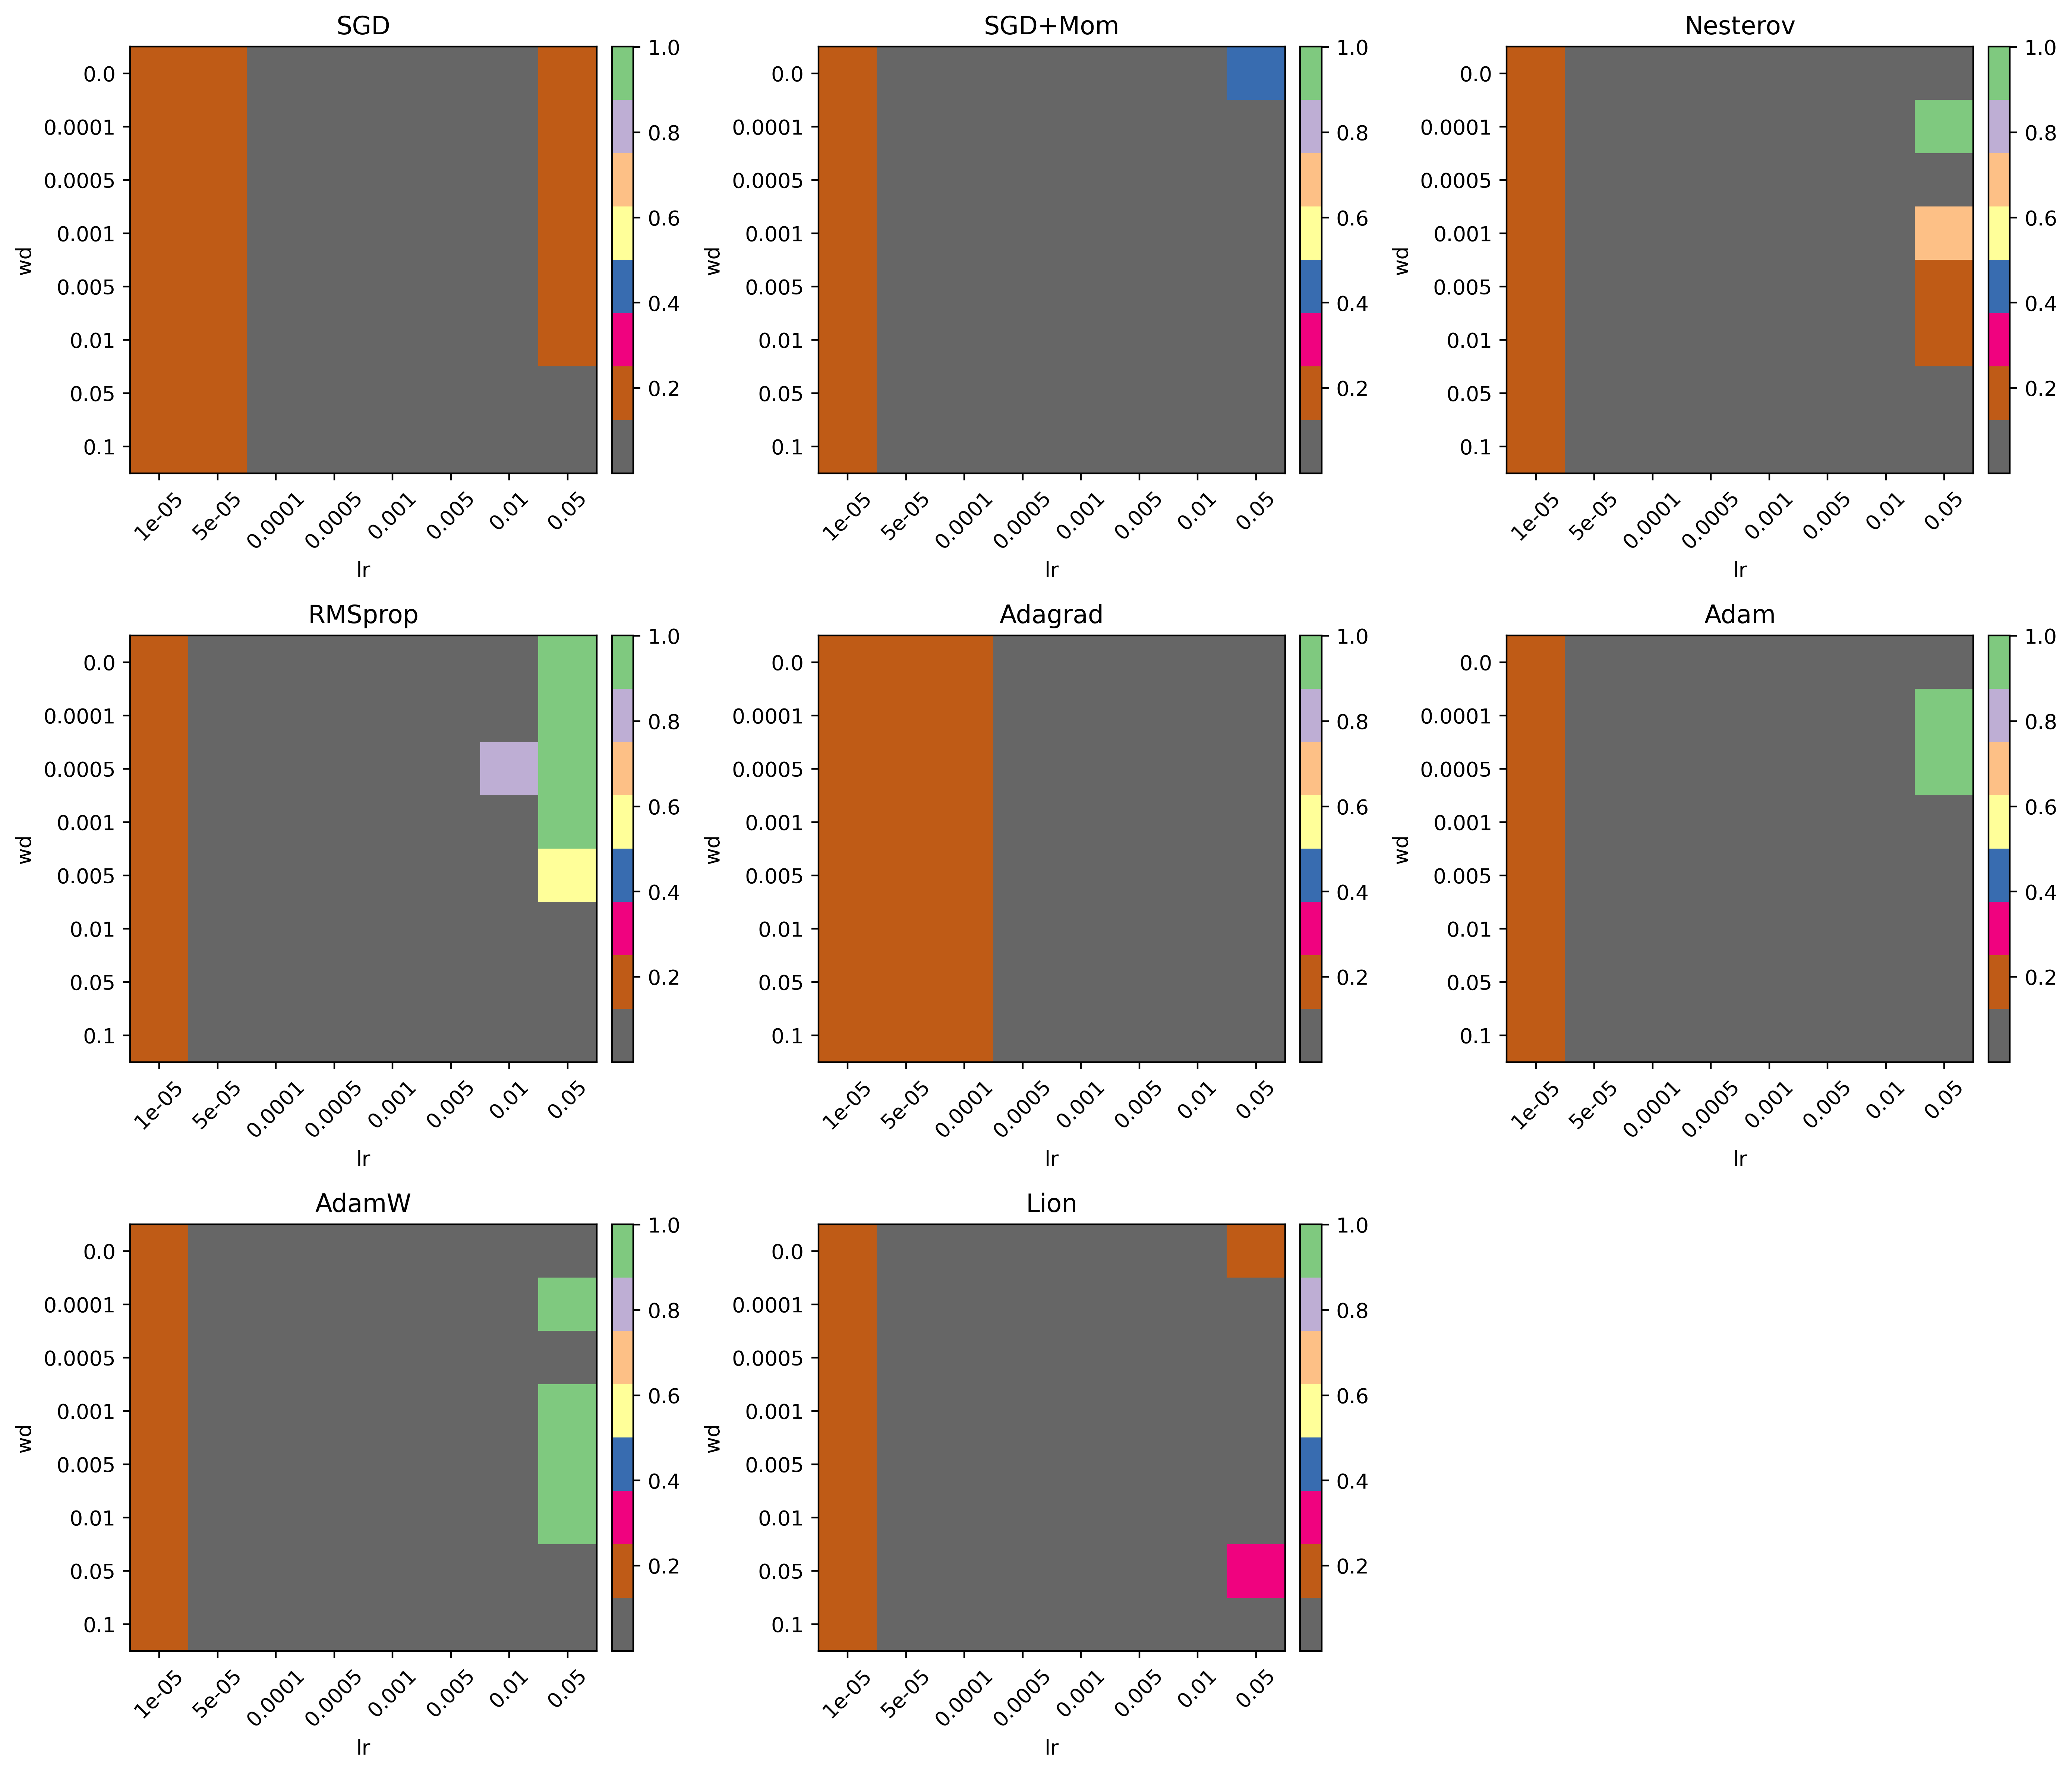

In [29]:
# heat‑map for Final Val MSE, shared scale among metrics
opts  = summary['Optimizer'].unique()
vmin  = summary['Final Val MSE'].min()
vmax  = summary['Final Val MSE'].max()

rows  = int(np.ceil(len(opts) / 3))
fig, axes = plt.subplots(rows, 3, figsize=(14, 4*rows), squeeze=False, dpi=400)

for ax, opt in zip(axes.flat, opts):
    sub = summary[summary['Optimizer'] == opt]
    pivot = sub.pivot(index='wd', columns='lr', values='Final Val MSE')
    im = ax.imshow(pivot, aspect='auto', vmin=vmin, vmax=vmax, cmap='Accent_r')
    ax.set_title(opt)
    ax.set_xlabel('lr')
    ax.set_ylabel('wd')
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=45)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    fig.colorbar(im, ax=ax, fraction=0.045, pad=0.03)
for blank in axes.flat[len(opts):]:
    blank.axis('off')

fig.tight_layout()
# fig.suptitle('Validation MSE landscape')
fig.savefig(os.path.join("/content", "Val-MSE-Heatmaps"), dpi=400)

plt.show()

In [13]:
opts = sorted(opts) # ensure deterministic order
base_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

colour_of = {opt: base_cycle[i] for i, opt in enumerate(opts)}

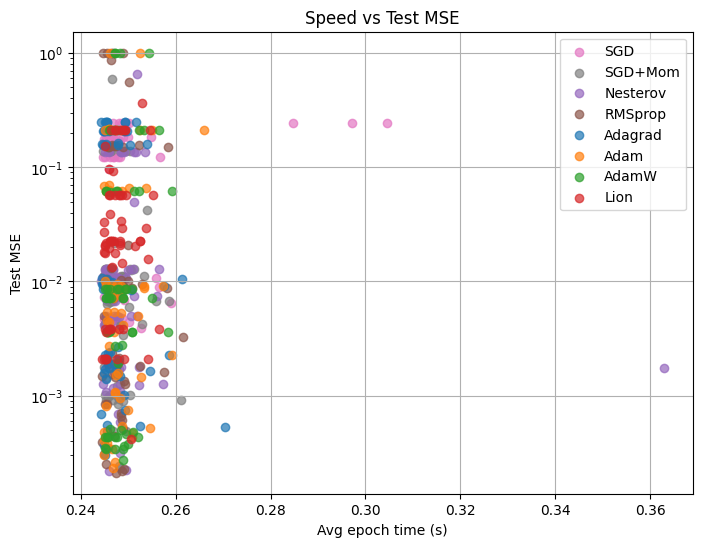

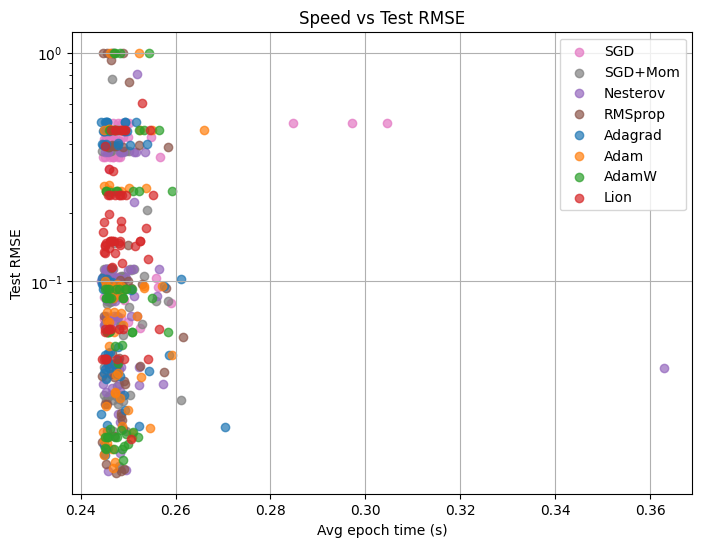

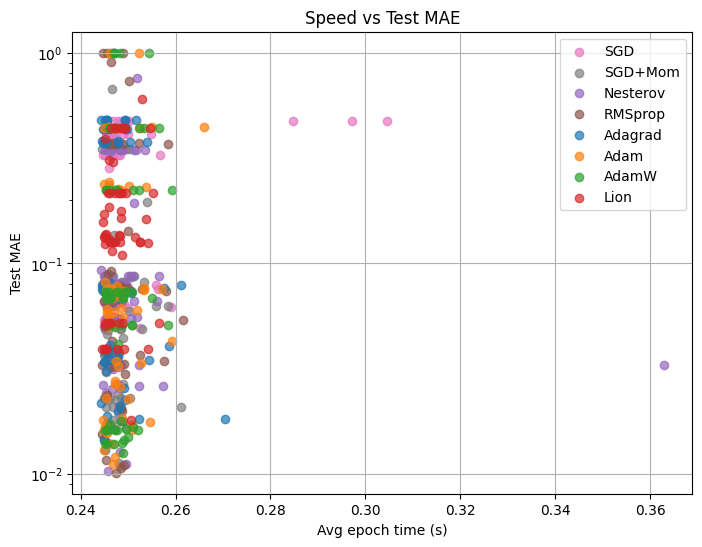

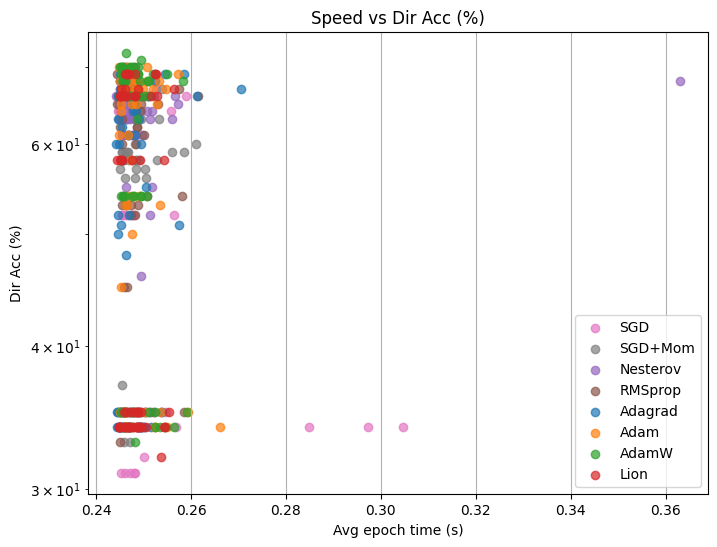

In [32]:
# speed‑vs‑metric scatter plots
metrics = ['Test MSE', 'Test RMSE', 'Test MAE', 'Dir Acc (%)']
for metric in metrics:
    fig = plt.figure(figsize=(8,6))
    for opt in opts:
        sub = summary[summary.Optimizer == opt]
        plt.scatter(sub['Avg Epoch Time (s)'], sub[metric], label=opt, alpha=0.7, color=colour_of[opt])
        plt.yscale('log')
    plt.xlabel('Avg epoch time (s)')
    plt.ylabel(metric)
    plt.title(f'Speed vs {metric}')
    plt.legend()
    plt.grid(True)
    fig.savefig(os.path.join("/content", f"Speed vs {metric}"), dpi=400)
    plt.show()

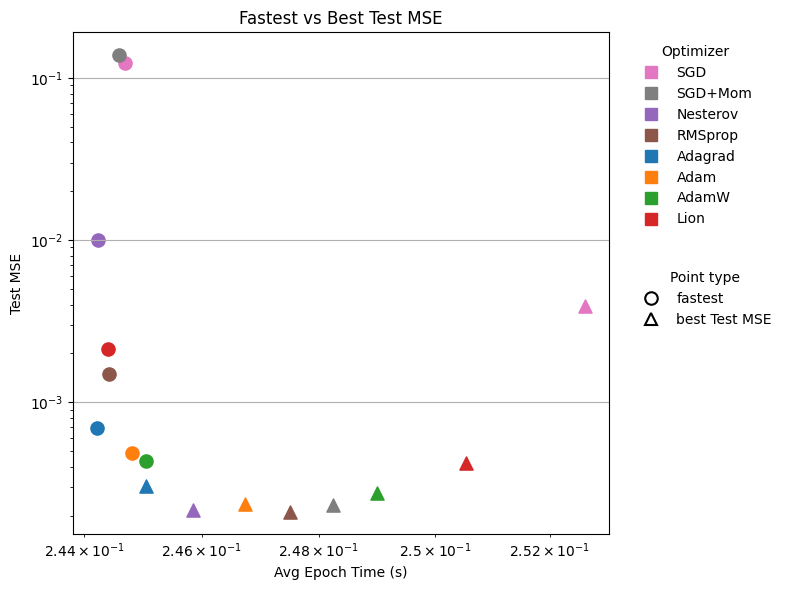

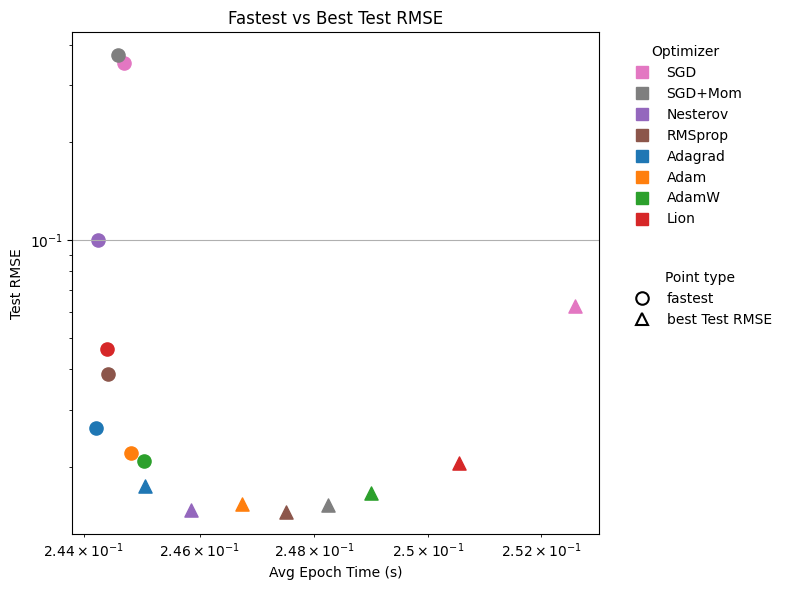

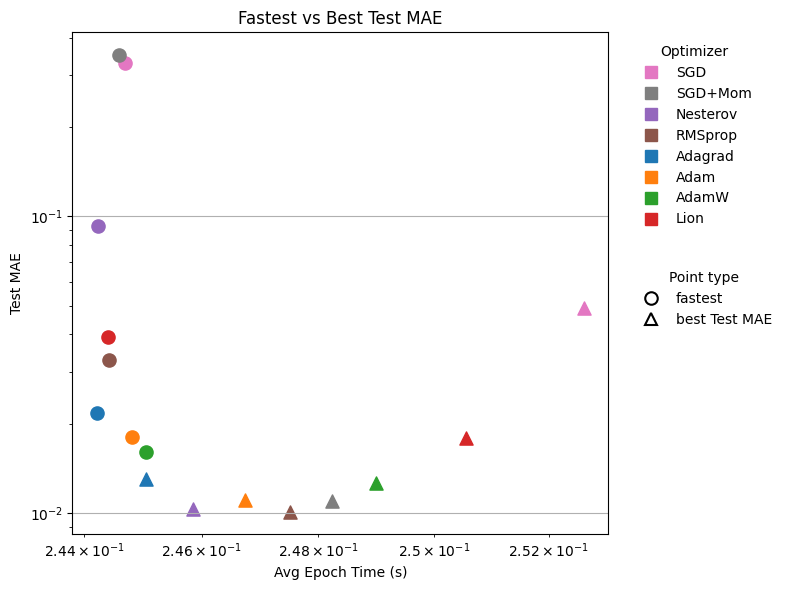

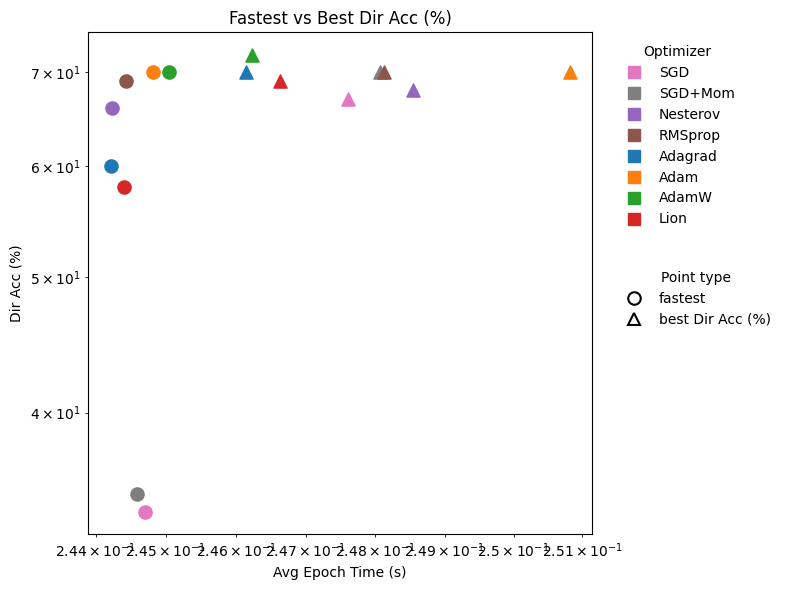

In [37]:
shape_of  = {'fastest': 'o', # circle = fastest
             'best':    '^'} # triangle = best metric

transparent = (0, 0, 0, 0)


for metric in metrics:
    fig, ax = plt.subplots(figsize=(8,6))
    for opt in opts:
        sub = summary[summary.Optimizer == opt]

        fastest = sub.loc[sub[time_col].idxmin()]
        if 'Acc' in metric or 'R²' in metric:
            best = sub.loc[sub[metric].idxmax()]
        else:
            best = sub.loc[sub[metric].idxmin()]

        col = colour_of[opt]
        ax.scatter(fastest[time_col], fastest[metric],
                   color=colour_of[opt], marker=shape_of['fastest'], s=90)
        ax.scatter(best[time_col],    best[metric],
                   color=colour_of[opt], marker=shape_of['best'], s=90)

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Avg Epoch Time (s)'); ax.set_ylabel(metric)
    ax.set_title(f'Fastest vs Best {metric}')
    ax.grid(True)

    opt_handles = [
        mlines.Line2D([], [], color=colour_of[o], marker='s', linestyle='None',
                      markersize=8, label=o) for o in opts
    ]
    leg1 = ax.legend(handles=opt_handles, title='Optimizer',
                     bbox_to_anchor=(1.03, 1), loc='upper left', frameon=False)
    ax.add_artist(leg1)

    type_handles = [
    mlines.Line2D([], [], marker=shape_of['fastest'],
                  markerfacecolor=transparent, markeredgecolor='k',
                  markeredgewidth=1.5, fillstyle='none',
                  linestyle='None', markersize=9,
                  label='fastest'),

    mlines.Line2D([], [], marker=shape_of['best'],
                  markerfacecolor=transparent, markeredgecolor='k',
                  markeredgewidth=1.5, fillstyle='none',
                  linestyle='None', markersize=9,
                  label=f'best {metric}')
    ]

    ax.legend(handles=type_handles, title='Point type',
          bbox_to_anchor=(1.03, 0.55), loc='upper left',
          frameon=False)


    plt.tight_layout()
    fig.savefig(os.path.join("/content", f"Fastest vs Best {metric}"), dpi=400)
    plt.show()

Optimizer surrogate  curv    lr    wd  Final Val MSE  Test MSE  Avg Epoch Time (s)
   Roaree      norm  1000 0.001   0.1       0.001521  0.001621              0.2559
   Roaree  softsign  1000 0.001   0.1       0.001154  0.001351              0.2656
   Roaree   sigmoid  1000 0.001   0.1      0.0006972 0.0008159              0.2512
   Roaree       erf    10  0.01   0.1       0.001213  0.001508              0.2451
   Roaree      tanh    10  0.01   0.1        0.00118  0.001478               0.249
   Roaree      atan    10  0.01   0.1       0.001179  0.001478              0.2472
      SGD       NaN   NaN  0.01   0.1       0.002637  0.003926              0.2526
  SGD+Mom       NaN   NaN  0.01   0.1      0.0004864 0.0004946              0.2468
 Nesterov       NaN   NaN  0.01   0.1      0.0003234 0.0003165              0.2483
  RMSprop       NaN   NaN  0.01   0.1      0.0003481 0.0002297              0.2492
  Adagrad       NaN   NaN  0.01 0.001      0.0009659  0.001568               0.245
    

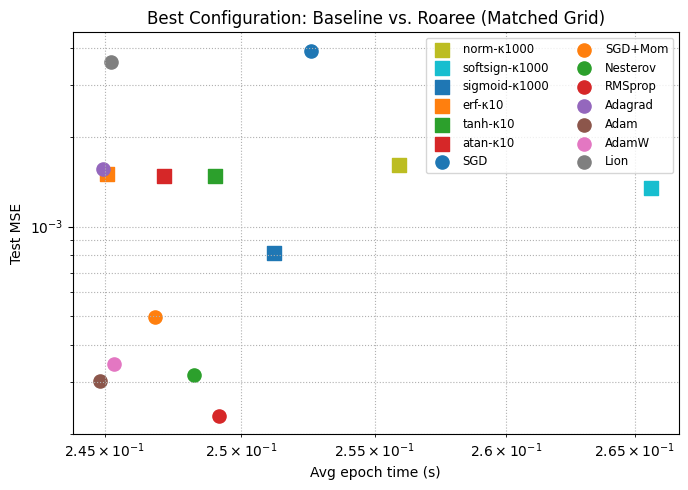

In [28]:
lr_grid = [1e-4, 1e-3, 1e-2]
wd_grid = [0, 1e-3, 1e-2, 1e-1]

roaree_files = [
    'exp-data/optimizer_results_log_roaree_norm-softsign.csv',
    'exp-data/optimizer_results_log_roaree_norm-softsign1000.csv',
    'exp-data/optimizer_results_log_mini_roaree_sigmoid-erf.csv',
    'exp-data/optimizer_results_log_mini_roaree_tanh-atan.csv'
]
roaree = pd.concat([pd.read_csv(f) for f in roaree_files], ignore_index=True)
roaree = roaree[roaree['curv'] != 500]

base = pd.read_csv('exp-data/optimizer_results_log.csv')

baseline_names = ['SGD','SGD+Mom','Nesterov','RMSprop',
                  'Adagrad','Adam','AdamW','Lion']

base = base[
    base['Optimizer'].isin(baseline_names)
    & base['lr'].isin(lr_grid)
    & base['wd'].isin(wd_grid)
]

rows = []

for s in ['norm','softsign','sigmoid','erf','tanh','atan']:
    sub = roaree[roaree['surrogate'] == s]
    if not sub.empty:
        rows.append(sub.loc[sub['Test MSE'].idxmin()])

for opt in baseline_names:
    sub = base[base['Optimizer'] == opt]
    if not sub.empty:
        rows.append(sub.loc[sub['Test MSE'].idxmin()])

best = pd.DataFrame(rows).reset_index(drop=True)

base_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colour_of = {opt: base_cycle[i] for i, opt in enumerate(baseline_names)}

extra_hues = cycle(base_cycle[len(baseline_names):] + base_cycle)
for tag in best['surrogate'].dropna().unique():
    if tag not in colour_of:
        colour_of[tag] = next(extra_hues)

print(
    textwrap.dedent(
        best[['Optimizer','surrogate','curv','lr','wd',
              'Final Val MSE','Test MSE','Avg Epoch Time (s)']]
        .to_string(index=False, float_format='{:0.4g}'.format))
)

best = best.replace([np.inf,-np.inf], np.nan).dropna(
       subset=['Avg Epoch Time (s)','Test MSE'])
best = best[(best['Avg Epoch Time (s)']>0) & (best['Test MSE']>0)]

fig = plt.figure(figsize=(7,5))
for _, r in best.iterrows():
    baseline = pd.isna(r['surrogate'])
    tag   = r['Optimizer'] if baseline else f"{r['surrogate']}-κ{int(r['curv'])}"
    key   = r['Optimizer'] if baseline else r['surrogate']
    mark  = 'o' if baseline else 's'
    plt.scatter(r['Avg Epoch Time (s)'], r['Test MSE'],
                s=90, marker=mark, color=colour_of[key], label=tag)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Avg epoch time (s)')
plt.ylabel('Test MSE')
plt.title('Best Configuration: Baseline vs. Roaree (Matched Grid)')
plt.grid(True, which='both', ls=':')
handles, labels = plt.gca().get_legend_handles_labels()
uniq = dict(zip(labels, handles)).values()
plt.legend(uniq, dict(zip(labels, handles)).keys(), fontsize='small', ncol=2)
plt.tight_layout()
fig.savefig(os.path.join("/content", f"MSE on baseline vs Roaree"), dpi=400)
plt.show()

In [30]:
def read_lines(path):
    return open(path).read().splitlines() if os.path.exists(path) else []

hist_files = [
    'exp-data/optim_history_log_roaree_norm-softsign.txt',
    'exp-data/optim_history_log_roaree_norm-softsign1000.txt',
    'exp-data/optim_history_log_sigmoid-erf.txt',
    'exp-data/optim_history_log_tanh-atan.txt',
    'exp-data/optim_history_log.txt'
]

log_lines = sum((read_lines(f) for f in hist_files), [])

lion_row = base[base['Optimizer'].str.contains('Lion', case=False)]
lion_row = lion_row.loc[lion_row['Final Val MSE'].idxmin()]

rows = []
for s in ['norm','softsign','sigmoid','erf','tanh','atan']:
    sub = roaree[roaree['surrogate'] == s]
    if not sub.empty:
        rows.append(sub.loc[sub['Final Val MSE'].idxmin()])
rows.append(lion_row)
best = pd.DataFrame(rows).reset_index(drop=True)

float_pat = r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?"

def find_history(r):
    tag = r['Optimizer']
    want_lr  = r['lr']
    want_wd  = r['wd']
    want_curv = r.get('curv', np.nan)
    want_surr = r.get('surrogate', np.nan)

    for line in log_lines:
        if not line.startswith(tag):
            continue
        if f"lr={want_lr}" not in line:
            continue
        if f"wd={want_wd}" not in line:
            continue
        # curv & surrogate may be 'nan' for Lion
        if not pd.isna(want_curv) and f"curv={int(want_curv)}" not in line:
            continue
        if not pd.isna(want_surr) and str(want_surr) not in line:
            continue

        # parse arrays
        tr = re.search(r"train_errors=\[(.*?)\]", line)
        va = re.search(r"val_errors=\[(.*?)\]", line)
        if tr and va:
            train = list(map(float, filter(None, tr.group(1).split(','))))
            val = list(map(float, filter(None, va.group(1).split(','))))
            return train, val
    return None, None

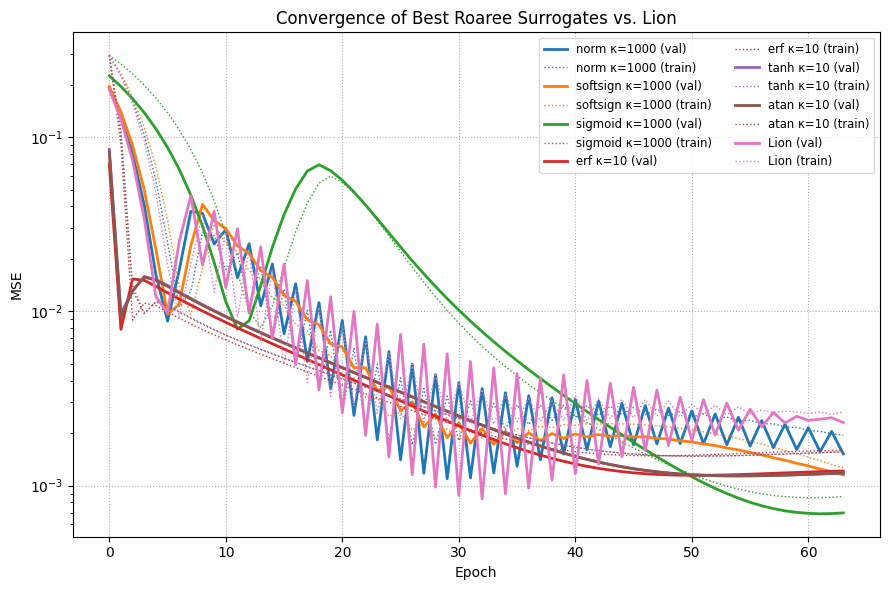

In [32]:
hues = cycle(plt.cm.tab10.colors)
colour_of = {}

fig = plt.figure(figsize=(9,6))

for _, row in best.iterrows():
    train, val = find_history(row)
    if train is None:
        print("history missing:", row['Optimizer'], row.get('surrogate'))
        continue

    label_root = ('Lion' if row['Optimizer'].lower().startswith('lion')
                  else f"{row['surrogate']} κ={int(row['curv'])}")
    # pick / remember colour for this optimizer
    if label_root not in colour_of:
        colour_of[label_root] = next(hues)
    c = colour_of[label_root]

    plt.plot(val, label=f"{label_root} (val)",   lw=2, color=c)
    plt.plot(train, label=f"{label_root} (train)", lw=1, ls=':', color=c)

plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.title('Convergence of Best Roaree Surrogates vs. Lion')
plt.grid(True, ls=':')
plt.legend(fontsize='small', ncol=2)
plt.tight_layout()

fig.savefig(os.path.join("/content", f"Convergence of Roaree"), dpi=400)
plt.show()